# PseU Modification Extraction
This script contains the extraction of information from bam files including uridines called as modified, U>C mismatches, deletions and other mismatches from all samples using pysam. First, the accuracy of each run is calculated based on 10.000 reads. Secondly, we extracted the basecalling patterns for -5 to +5 around the modified sites and calculated the percentage of modified (U>C mismatch or dorado called) reads for the position of interest in each run. 

### Samples description:
Three different HEK293T samples including two reporters each harboring one pseuouridine target and two control samples with the target motifs are used: 
1. Sample A (EGFP:115 mod high, mCherry:565 mod high, potential off-targets in HEK293T mRNAs)
2. Sample B (EGFP:115 mod low, mCherry:565 mod high, potential off-targets in HEK293T mRNAs)
3. Sample C (EGFP:115 mod low, mCherry: 565 mod low, potential off-targets in HEK293T mRNAs)
4. Control Oligo 1 (EGFP motif with 100 % pseU, mCherry motif with 0 % pseU)
5. Control Oligo 2 (mCherry motif with 100 % pseU, EGFP motif with 0 % pseU)


## Load libraries

In [3]:
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pylab as plt

In [4]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs)

# 1. Extract error pattern from samples

In [3]:
def extract_error_pattern_samples(bamFile, sample, contigs):
    samfile = pysam.AlignmentFile(bamFile, "rb")
    out_df = pd.DataFrame()
    for pileupcolumn in samfile.pileup(contigs[0], max_depth = 10000):
        #print(pileupcolumn.pos)
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            if len(mod_pos) > 0:
                ref_base = mod_pos[0][2]
                break
        #print(ref_base)  
        base_calls = pileupcolumn.get_query_sequences()
        y = [[x, base_calls.count(x)] for x in set(base_calls)]
        out1 = pd.DataFrame(y)
        out1["ref_pos"] = pileupcolumn.pos
        out1["ref_base"] = ref_base.upper()
        out1["Sample"] = sample
        out1["ref"] = contigs[0]
        out_df = pd.concat([out_df, out1], axis = 0)
    for pileupcolumn in samfile.pileup(contigs[1], max_depth = 10000):
        #print(pileupcolumn.pos)
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            if len(mod_pos) > 0:
                ref_base = mod_pos[0][2]
                break
        #print(ref_base)        
 
        base_calls = pileupcolumn.get_query_sequences()
        y = [[x, base_calls.count(x)] for x in set(base_calls)]
        out1 = pd.DataFrame(y)
        out1["ref_pos"] = pileupcolumn.pos
        out1["ref_base"] = ref_base.upper()
        out1["Sample"] = sample
        out1["ref"] = contigs[1]
        out_df = pd.concat([out_df, out1], axis = 0)
 
    samfile.close()
    out_df.columns = ["base_called", "Nreads", "ref_pos", "ref_base", "Contig", "Ref"]
    out_df["condition"] = "canonical"
    out_df.loc[out_df.base_called == "", "condition"] = "deletion"
    out_df.loc[(out_df.base_called == "A") & (out_df.ref_base != "A"), "condition"]= "mismatch_AGU"
    out_df.loc[(out_df.base_called == "G") & (out_df.ref_base != "G"), "condition"]= "mismatch_AGU"
    out_df.loc[(out_df.base_called == "T") & (out_df.ref_base != "T"), "condition"]= "mismatch_AGU"
    out_df.loc[(out_df.base_called == "C") & (out_df.ref_base != "C"), "condition"]= "mismatch_C"
   
    return(out_df)

In [4]:
contigs = ["EGFP", "mCherry"]

bamFile = "RNA004_SampleA_basecall.ROI.bam"
sample = "Sample A"
Sample_A_mpileup = extract_error_pattern_samples(bamFile, sample, contigs)

bamFile = "RNA004_SampleB_basecall.ROI.bam"
sample = "Sample B"
Sample_B_mpileup = extract_error_pattern_samples(bamFile, sample, contigs)

bamFile = "RNA004_SampleC_basecall.ROI.bam"
sample = "Sample C"
Sample_C_mpileup = extract_error_pattern_samples(bamFile, sample, contigs)


In [5]:
Samples_mpileup = pd.concat([Sample_A_mpileup, Sample_B_mpileup, Sample_C_mpileup], axis = 0)
Samples_mpileup.to_csv("RNA004_samples_r10000.mpileup")

In [6]:
Samples_mpileup_flat = Samples_mpileup[~(Samples_mpileup["condition"] == "deletion")]
samples_accuracy = Samples_mpileup_flat.groupby(["Contig", "ref_base", "base_called"]).Nreads.sum().reset_index()
samples_accuracy['%'] = 100 * samples_accuracy['Nreads'] / samples_accuracy.groupby(["Contig", "ref_base"])['Nreads'].transform('sum')

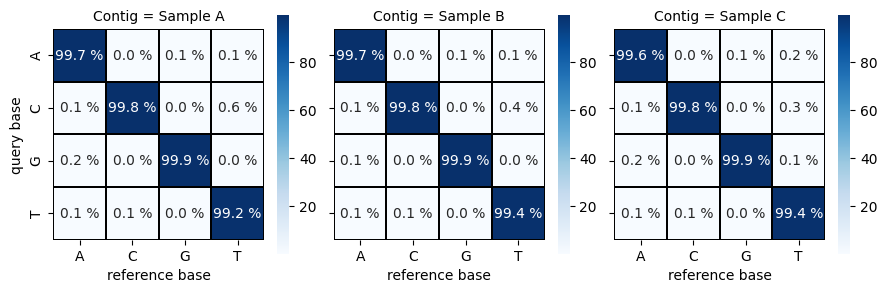

In [8]:
fg = sns.FacetGrid(samples_accuracy, col='Contig')
fg.map_dataframe(draw_heatmap, 'ref_base', 'base_called', '%', cbar=True,cmap="Blues",  fmt = '.1f', square = True, linewidth = .003, linecolor = "black", annot = True)
fg.set_axis_labels("reference base", "query base")
# get figure background color
for ax in fg.axes.flat:
    # set aspect of all axis
    ax.set_aspect('equal','box')
    for t in ax.texts: t.set_text(t.get_text() + " %")
plt.savefig('samples_accuracy.pdf')
plt.savefig('samples_accuracy_r10000_q13.svg')

# 2. Extract Error pattern from oligos

In [9]:
def extract_error_pattern_oligos(bamFile, contig):
    samfile = pysam.AlignmentFile(bamFile, "rb")
    out_df = pd.DataFrame()
    for pileupcolumn in samfile.pileup(contig, max_depth = 10000):
        #print(pileupcolumn.pos)
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            if len(mod_pos) > 0:
                ref_base = mod_pos[0][2]
                break
        #print(ref_base)  
        base_calls = pileupcolumn.get_query_sequences()
        y = [[x, base_calls.count(x)] for x in set(base_calls)]
        out1 = pd.DataFrame(y)
        out1["ref_pos"] = pileupcolumn.pos
        out1["ref_base"] = ref_base.upper()
        out1["Sample"] = contig
        out1["ref"] = contig
        out_df = pd.concat([out_df, out1], axis = 0)
 
    samfile.close()
    out_df.columns = ["base_called", "Nreads", "ref_pos", "ref_base", "Contig", "Ref"]
    out_df["condition"] = "canonical"
    out_df.loc[out_df.base_called == "", "condition"] = "deletion"
    out_df.loc[(out_df.base_called == "A") & (out_df.ref_base != "A"), "condition"]= "mismatch_AGU"
    out_df.loc[(out_df.base_called == "G") & (out_df.ref_base != "G"), "condition"]= "mismatch_AGU"
    out_df.loc[(out_df.base_called == "T") & (out_df.ref_base != "T"), "condition"]= "mismatch_AGU"
    out_df.loc[(out_df.base_called == "C") & (out_df.ref_base != "C"), "condition"]= "mismatch_C"
   
    return(out_df)

In [10]:
bamFile = "./../RNA004_GFPPsi_mCherry_basecall.ROI.bam"
contig = "F1_GFPPsi_mCherry"
GFP_mpileup = extract_error_pattern_oligos(bamFile, contig)
bamFile = "./../RNA004_mCherryPsi_GFP_basecall.ROI.bam"
contig = "F3_mCherryPsi_GFP"
mCherry_mpileup = extract_error_pattern_oligos(bamFile, contig)


In [11]:
controls_mpileup = pd.concat([GFP_mpileup, mCherry_mpileup], axis = 0)
controls_mpileup_flat = controls_mpileup[~(controls_mpileup.base_called == "")]
controls_accuracy = controls_mpileup_flat.groupby(["Contig", "ref_base", "base_called"]).Nreads.sum().reset_index()
controls_accuracy['%'] = 100 * controls_accuracy['Nreads'] / controls_accuracy.groupby(["Contig", "ref_base"])['Nreads'].transform('sum')

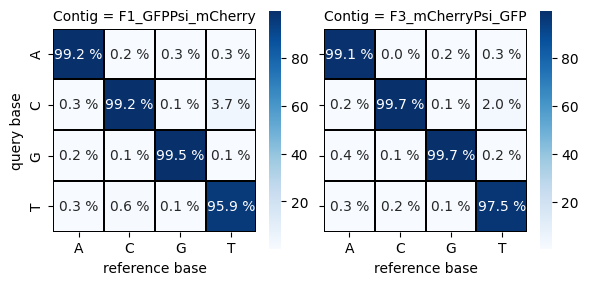

In [12]:
fg = sns.FacetGrid(controls_accuracy, col='Contig')
fg.map_dataframe(draw_heatmap, 'ref_base', 'base_called', '%', cbar=True,cmap="Blues",  fmt = '.1f', square = True, linewidth = .003, linecolor = "black", annot = True)
fg.set_axis_labels("reference base", "query base")
# get figure background color
for ax in fg.axes.flat:
    # set aspect of all axis
    ax.set_aspect('equal','box')
    for t in ax.texts: t.set_text(t.get_text() + " %")
plt.savefig('oligos_accuracy_r10000.pdf')
plt.savefig('oligos_accuracy_r10000.svg')


# 3. Extract U>C mismatch percentages and modification calls from dorado for regions of interest

In [18]:
def extract_modifcation_infos(i, out_df_mod, mod_pos, threshold):
    mod_obj = i.modified_bases
    mod_info = [m for m in list(mod_obj.values())[0] if m[0] == mod_pos[0][0]]
 
    if len(mod_info) == 0:
        mod_info = [(mod_pos[0][0],0)]
        modprob = 0
        if mod_pos[0][2] in ["t", "a", "g", "c"]:
            called_base = i.query_sequence[mod_pos[0][0]]
            if called_base == "C":
                out_df_mod["mismatch_C"] += 1
            else:
                out_df_mod["mismatch_AUG"] += 1
        elif mod_pos[0][0] == None:
            out_df_mod["deletion"] += 1
        else:
            out_df_mod["canonical"] += 1
   
    else:
        modprob = (mod_info[0][1]+1)/256
        if modprob < threshold:
            out_df_mod["fail"] += 1
        else:
            out_df_mod["modified"] += 1
    return(out_df_mod)
 
def extract_dorado_calls_10mer(bamFile, sample, threshold = 0.95):
    samfile = pysam.AlignmentFile(bamFile, "rb")
    tmp_EGFP_out = pd.DataFrame()
    tmp_mCherry_out = pd.DataFrame()
 
    for pileupcolumn in samfile.pileup("EGFP", start = 109, end = 120, truncate = True, max_depth = 100000, min_base_quality=13): #defaul min_base_qualiy = 13
        print(pileupcolumn.pos)
        out_df_mod = {"mismatch_C" : 0, "mismatch_AUG" : 0, "canonical" : 0, "deletion" : 0, "modified" : 0, "fail"  : 0}
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            i = pileupread.alignment
            if i.is_supplementary:
                continue
            if len(mod_pos) > 0:
                out_df_mod = extract_modifcation_infos(i, out_df_mod, mod_pos, threshold)
        tmp = pd.DataFrame.from_dict(out_df_mod, orient = "index")
        tmp["ref_pos"] = pileupcolumn.pos
        tmp_EGFP_out = pd.concat([tmp, tmp_EGFP_out], axis = 0)
    tmp_EGFP_out["Ref"] = "EGFP"
    for pileupcolumn in samfile.pileup("mCherry", start = 559, end = 570, truncate = True, max_depth = 100000, min_base_quality=13): #defaul min_base_qualiy = 13
        print(pileupcolumn.pos)
        out_df_mod = {"mismatch_C" : 0, "mismatch_AUG" : 0, "canonical" : 0, "deletion" : 0, "modified" : 0, "fail"  : 0}
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            i = pileupread.alignment
            if i.is_supplementary:
                continue
            if len(mod_pos) > 0:
                out_df_mod = extract_modifcation_infos(i, out_df_mod, mod_pos, threshold)
        tmp = pd.DataFrame.from_dict(out_df_mod, orient = "index")
        tmp["ref_pos"] = pileupcolumn.pos
        tmp_mCherry_out = pd.concat([tmp, tmp_mCherry_out], axis = 0)
    tmp_mCherry_out["Ref"] = "mCherry"
    out_df = pd.concat([tmp_mCherry_out.reset_index(), tmp_EGFP_out.reset_index()], axis = 0)
    out_df["Contig"] = sample
    out_df.columns = ["condition", "Nreads", "ref_pos", "Ref", "Contig"]
    return(out_df)



def extract_dorado_calls_oligos_10mer(bamFile, sample, refs, threshold = 0.95):
    samfile = pysam.AlignmentFile(bamFile, "rb")
    tmp_1_out = pd.DataFrame()
    tmp_2_out = pd.DataFrame()

    for pileupcolumn in samfile.pileup(sample, start = 68, end = 79, truncate = True, max_depth = 100000, min_base_quality=13): #defaul min_base_qualiy = 13
        print(pileupcolumn.pos)
        out_df_mod = {"mismatch_C" : 0, "mismatch_AUG" : 0, "canonical" : 0, "deletion" : 0, "modified" : 0, "fail"  : 0}
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            i = pileupread.alignment
            if i.is_supplementary:
                continue
            if len(mod_pos) > 0:
                out_df_mod = extract_modifcation_infos(i, out_df_mod, mod_pos, threshold)   
        tmp = pd.DataFrame.from_dict(out_df_mod, orient = "index")
        tmp["ref_pos"] = pileupcolumn.pos
        tmp_1_out = pd.concat([tmp, tmp_1_out], axis = 0)
    tmp_1_out["Ref"] = refs[0]
    for pileupcolumn in samfile.pileup(sample, start = 108, end = 119, truncate = True, max_depth = 100000, min_base_quality=13): #defaul min_base_qualiy = 13
        print(pileupcolumn.pos)
        out_df_mod = {"mismatch_C" : 0, "mismatch_AUG" : 0, "canonical" : 0, "deletion" : 0, "modified" : 0, "fail"  : 0}
        for pileupread in pileupcolumn.pileups:
            mod_pos = [m for m in pileupread.alignment.get_aligned_pairs(with_seq=True) if m[1] == pileupcolumn.pos]
            i = pileupread.alignment
            if i.is_supplementary:
                continue
            if len(mod_pos) > 0:
                out_df_mod = extract_modifcation_infos(i, out_df_mod, mod_pos, threshold)
        tmp = pd.DataFrame.from_dict(out_df_mod, orient = "index")
        tmp["ref_pos"] = pileupcolumn.pos
        tmp_2_out = pd.concat([tmp, tmp_2_out], axis = 0)
    tmp_2_out["Ref"] = refs[1]
    out_df = pd.concat([tmp_1_out.reset_index(), tmp_2_out.reset_index()], axis = 0)
    out_df["Contig"] = sample
    out_df.columns = ["condition", "Nreads", "ref_base", "Ref", "Contig"]
    return(out_df)

 

### 1. Samples

In [12]:
bamFile = "RNA004_A_basecall.vector.ROI.bam"
sample = "Sample A"
Sample_A_mpileup = extract_dorado_calls_10mer(bamFile, sample)

bamFile = "RNA004_B_basecall.vector.ROI.bam"
sample = "Sample B"
Sample_B_mpileup = extract_dorado_calls_10mer(bamFile, sample)

bamFile = "RNA004_Control_basecall.ROI.bam"
sample = "Sample C"
Sample_C_mpileup = extract_dorado_calls_10mer(bamFile, sample)

samples_10mer = pd.concat([Sample_A_B_mpileup, Sample_C_mpileup], axis = 0)
samples_10mer.to_csv("Basecalling_error_pattern_10mer_samples.csv")

109
110
111
112
113
114
115
116
117
118
119
559
560
561
562
563
564
565
566
567
568
569


In [36]:
samples_mpileup_flat = samples_10mer[~(samples_10mer["condition"].isin(["deletion", "mismatch_AUG"]))]
samples_mpileup_flat["modified"] = ["C_mismatch+modification call" if m in ["modified", "mismatch_C"] else "unmodified" for m in samples_mpileup_flat["condition"]]

samples_accuracy = samples_mpileup_flat.groupby(["Ref", "Contig", "ref_pos", "modified"]).Nreads.sum().reset_index()
samples_accuracy['%'] = 100 * samples_accuracy['Nreads'] / samples_accuracy.groupby(["Ref", "Contig", "ref_pos"])['Nreads'].transform('sum')
samples_accuracy[samples_accuracy["ref_pos"].isin([114, 564])].to_csv("Joined_approach_UC_mismatch_dorado_call_p95_q13_100000reads.tsv", sep = "\t")

/tmp/ipykernel_137893/3705074828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_mpileup_flat["modified"] = ["C_mismatch+modification call" if m in ["modified", "mismatch_C"] else "unmodified" for m in samples_mpileup_flat["condition"]]


In [40]:
samples_mpileup_flat['%'] = 100 * samples_mpileup_flat['Nreads'] / samples_mpileup_flat.groupby(["Ref", "Contig", "ref_pos"])['Nreads'].transform('sum')
samples_mpileup_flat[samples_mpileup_flat["ref_pos"].isin([114, 564])]

/tmp/ipykernel_137893/1230724740.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_mpileup_flat['%'] = 100 * samples_mpileup_flat['Nreads'] / samples_mpileup_flat.groupby(["Ref", "Contig", "ref_pos"])['Nreads'].transform('sum')


,Unnamed: 0,condition,Nreads,ref_pos,Ref,Contig,modified,%
30,30.0,mismatch_C,25089,564,mCherry,Sample A,C_mismatch+modification call,28.723697
32,32.0,canonical,16707,564,mCherry,Sample A,unmodified,19.127378
34,34.0,modified,43588,564,mCherry,Sample A,C_mismatch+modification call,49.902686
35,35.0,fail,1962,564,mCherry,Sample A,unmodified,2.246239
96,30.0,mismatch_C,26598,114,EGFP,Sample A,C_mismatch+modification call,29.109893
98,32.0,canonical,49514,114,EGFP,Sample A,unmodified,54.190060
100,34.0,modified,877,114,EGFP,Sample A,C_mismatch+modification call,0.959823
101,35.0,fail,14382,114,EGFP,Sample A,unmodified,15.740224
162,30.0,mismatch_C,19390,564,mCherry,Sample B,C_mismatch+modification call,21.568169
164,32.0,canonical,35112,564,mCherry,Sample B,unmodified,39.056295


### 2. Oligos

In [20]:
bamFile = "./../RNA004_GFPPsi_mCherry_basecall.ROI.bam"
sample = "F1_GFPPsi_mCherry"
refs = ["EGFP", "mCherry"]
GFP_mpileup = extract_dorado_calls_oligos_10mer(bamFile, sample,refs)
bamFile = "./../RNA004_mCherryPsi_GFP_basecall.ROI.bam"
sample = "F3_mCherryPsi_GFP"
refs = ["mCherry", "EGFP"]
mCherry_mpileup = extract_dorado_calls_oligos_10mer(bamFile, sample, refs)

oligos_10mer = pd.concat([mCherry_mpileup, GFP_mpileup], axis = 0)
oligos_10mer.to_csv("Basecalling_error_pattern_10mer_oligos.csv")


68
69
70
71
72
73
74
75
76
77
78
108
109
110
111
112
113
114
115
116
117
118
68
69
70
71
72
73
74
75
76
77
78
108
109
110
111
112
113
114
115
116
117
118


In [26]:
oligos_mpileup_flat = oligos_10mer[~(oligos_10mer["condition"].isin(["deletion", "mismatch_AUG"]))]
oligos_mpileup_flat["modified"] = ["C_mismatch+modification call" if m in ["modified", "mismatch_C"] else "unmodified" for m in oligos_mpileup_flat["condition"]]

oligos_accuracy = oligos_mpileup_flat.groupby(["Ref", "Contig", "ref_base", "modified"]).Nreads.sum().reset_index()
oligos_accuracy['%'] = 100 * oligos_accuracy['Nreads'] / oligos_accuracy.groupby(["Ref", "Contig", "ref_base"])['Nreads'].transform('sum')
oligos_accuracy[oligos_accuracy["ref_base"].isin([73, 113])].to_csv("Joined_approach_UC_mismatch_dorado_call_p95_q13_100000reads_olgios.tsv", sep = "\t")

/tmp/ipykernel_137893/1875870780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oligos_mpileup_flat["modified"] = ["C_mismatch+modification call" if m in ["modified", "mismatch_C"] else "unmodified" for m in oligos_mpileup_flat["condition"]]


In [44]:
oligos_accuracy[oligos_accuracy["ref_base"].isin([73, 113])]

,Ref,Contig,ref_base,modified,Nreads,%
10,EGFP,F1_GFPPsi_mCherry,73,C_mismatch+modification call,68282,96.599044
11,EGFP,F1_GFPPsi_mCherry,73,unmodified,2404,3.400956
32,EGFP,F3_mCherryPsi_GFP,113,C_mismatch+modification call,2561,4.361153
33,EGFP,F3_mCherryPsi_GFP,113,unmodified,56162,95.638847
54,mCherry,F1_GFPPsi_mCherry,113,C_mismatch+modification call,1201,1.409955
55,mCherry,F1_GFPPsi_mCherry,113,unmodified,83979,98.590045
76,mCherry,F3_mCherryPsi_GFP,73,C_mismatch+modification call,56474,91.796297
77,mCherry,F3_mCherryPsi_GFP,73,unmodified,5047,8.203703
